# Computational Biology (TP1): Salmonella Outbreak

### by Anastasia Gorbunova, Alim Bukharaev and Adrian Deverin

As everyone knows, a disastrous salmonella outbreak is currently happening all over the world. Millions of people die everyday, and antibiotics do not help at all. For that reason, it is supposed that some mutation has happened in the salmonella gene, which should be detected and understood.

Fortunately, one talented biologist has managed to obtain two gene strains: one of the resistant mutant, and one of the wild salmonella. In this notebook we undrtake to localize this deadly mutation and provide the reader with code we used and the mathematical reasoning behind it.

In case you have any questions, please feel free to contact us at bukharaev.an@phystech.edu

## To start, let's first do all the necessary imports and load the input data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install biopython
!pip install Levenshtein

In [ ]:
import Bio
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from difflib import SequenceMatcher
from functools import partial

from tqdm import tqdm_notebook as tqdm
from time import time
import copy
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as sps

import Levenshtein as lev

Let's read DNA records for both the organsms.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%time

wild_dna_records = []
mutated_dna_records = []

# here one should use their own paths to the input files

for seq_record in SeqIO.parse('drive/MyDrive/computation_biology/salmonella-enterica.reads.fna', 'fasta'):
    wild_dna_records.append(str(seq_record.seq))
    
for seq_record in SeqIO.parse('drive/MyDrive/computation_biology/salmonella-enterica-variant.reads.fna', 'fasta'):
    mutated_dna_records.append(str(seq_record.seq))

CPU times: user 41.6 s, sys: 3.62 s, total: 45.3 s
Wall time: 51 s


## Tackling the problem using the k-mer analysis


As input data, we have reads of two biological sequences, of the wild salmonella and a strain resistant to the tetracycline. Reads are simply chunks of the original strains of length 250, which overlap (enabling the so-called sequencing depth) and fully cover the original biological sequences.

To find the differences between the two original strains, we use the so-called k-mer technique. In bioinformatics, k-mers are simply substrings of length k of some original biological sequence. K-mers are shorter than reads, and will help us get rid of the sequencing errors (about 1%), which are inevitable when working with raw seqential data due to the imperfections of gene processing machines.

### Mathematical background

Now we would like to go through some mathematical theory on which our solution is based.

Suppose we have reads of length $L = 250$ while the original gene is of the length $G = 5 * 10^6$. 

Then, the probability that a certain read overlaps an original strain at the position $i$ is:

$$P_i = \frac{L}{G - L + 1}$$

Suppose $X_i$ is number of reads overlapping the position $i$. Then, we can use binomial distribution to model it. Such distribution is used to model the number of succesful trials of $N$ total trials and with $p$ being the probability of success for each one of them. This is why:

$$X_i \sim Binomial\left(N, \frac{L}{G - L + 1}\right)$$

Similarly, the probability of a read overlapping a $k$-mer at position $i$ is 

$$\Pi_i = \frac{L - K + 1}{G - L + 1}$$

And the number of reads overlapping a k-mer at position $i$ is:

$$\chi_i \sim Binomial\left(N, \frac{L - K + 1}{G - L + 1}\right)$$

As N is much bigger than $\frac{L - K + 1}{G - L + 1}$, we can go from the binomial distribution to Poisson distribution as:

$$Y \sim Pos\left( N \cdot \frac{L-k+1}{G} \right)$$

where $Y$ stands for the number of times a certain k-mer is present in the reads.

We have to take into account that some k-mers could be present several times trough the original strain, so we expect to see the mixture of Poisson distributions, not just a single one. We also expect to see the error spike in the leftmost part of the graph, as the erroneous k-mers will stand out by their scarcity.

Now, we woluld like to try different ks until we clearly see the mixture of Poisson distributions with harmonic rates and a distinguishable error spike. 

### Let's code the functions we need for this

In [ ]:
def calculate_patterns_frequency(records, k):
    """
    Given a list reads, the function calculates how often each
    k-mer of length k is present in the reads.

    input: a list of reads, k: int
    output: patterns: dict like {kmer: number of its occurences}
    """
    patterns = defaultdict(lambda: 0)
    pattern_lenght = k

    for record in tqdm(records, leave=False, total=1993167):
        for start_position in range(250 - k + 1):
            pattern = record[start_position: start_position + k]
            patterns[pattern] += 1

    return patterns


def calculate_patterns_frequency_with_origin(records, k):
    """
    Same as calculate_patterns_frequency, but also outputs a dictionary
    of the indices of the reads each fourth k-mer came from.
    This is needed for the algorithm evaluation using the blast database,
    as it can't process short chunks of genes.

    input: a list of reads, k: int
    output: (patterns: dict like {kmer: number of its occurences},
             origins: dict like {kmer: index of the source read})
    """
    patterns = defaultdict(lambda: 0)
    origins = defaultdict(lambda: None)
    pattern_lenght = k

    count = 0

    for i, record in tqdm(enumerate(records), leave=False, total=1993167):
        for start_position in range(250 - k + 1):
            pattern = record[start_position: start_position + k]
            patterns[pattern] += 1
            if pattern not in origins.keys() and count % 4 == 0:
                origins[pattern] = i
            count += 1

    return patterns, origins


def plot_for_k(k, patterns, plot_theoretical=False, x_lim=400):
    """
    A function which plots the histogram for a given dictionary, 
    which contains the number of k-mer occurences.

    input: k: int
    patterns: a dictionary like {kmer: number of its occurences}
    plot_theoretical: bool, indicates whether to plot or not the
                      theoretical Poisson distribution expected
    x_lim: plot parameter
    """
    plt.figure(figsize=(25, 5))  
    x = range(0, 200)
    sns.histplot(data=patterns.values(), binwidth=1)

    if plot_theoretical:
        # here we calculate the parameters of the Poisson distribution and 
        # scale it
        N = 1993167
        L = 250
        G = 5 * (10 ** 6)
        p = (L - k + 1) / G
        mu = N * p
        coefficent = sum([v for k, v in patterns.items() if 25 < v and v < 75])
        plt.plot(x, sps.poisson.pmf(x, N * p) * coefficent / mu, color='green')

    plt.title(f'k = {k}', fontsize=20)
    plt.xlabel('Frequency', fontsize=20)
    plt.ylabel('Number of patterns', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(0, x_lim)
    plt.grid()        
    plt.tight_layout()

    plt.savefig(f'drive/MyDrive/computation_biology/pics/pic_{k}_{time()}.png')
    plt.show()

### First, let's try k = 25

In [ ]:
k = 25

wild_patterns = calculate_patterns_frequency(wild_dna_records, k)

  0%|          | 0/1993167 [00:00<?, ?it/s]

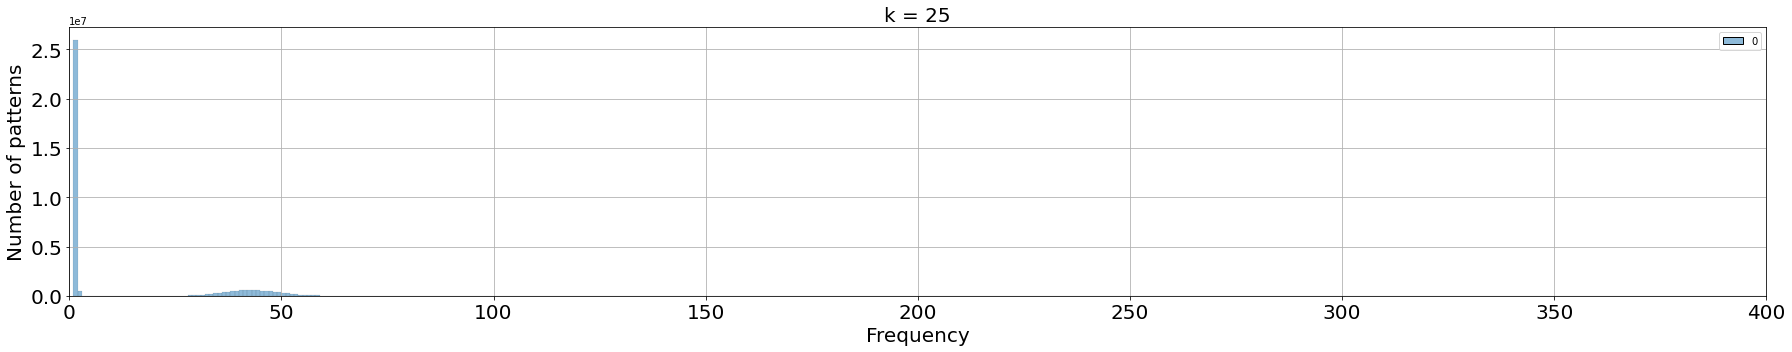

In [ ]:
plot_for_k(k, wild_patterns)

#### Now, without outliers:

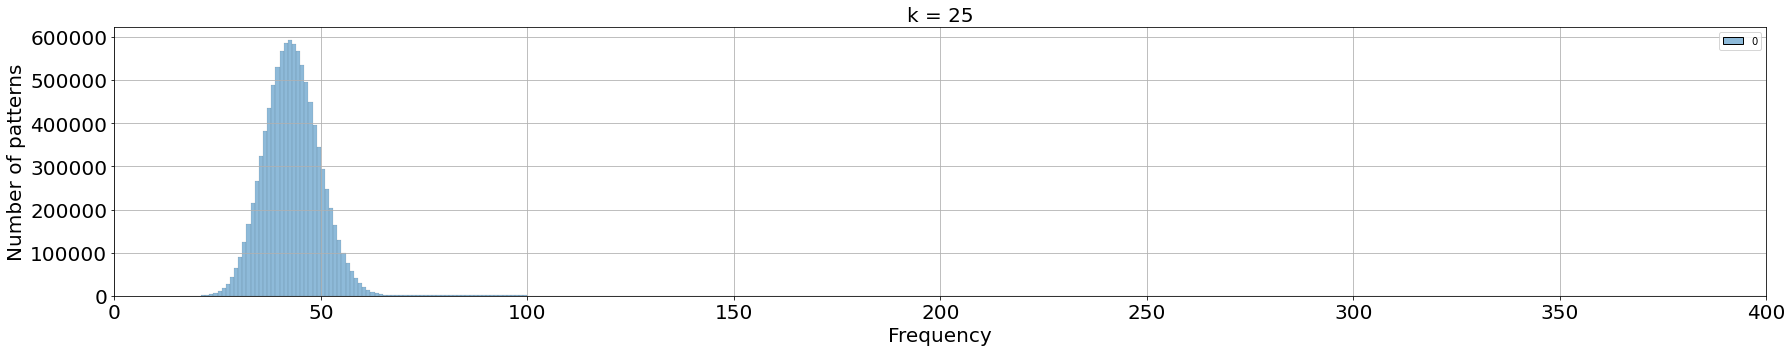

In [ ]:
outliers_thr = 15

filtered_wild = {k: v for k, v in wild_patterns.items() if v > outliers_thr}

del wild_patterns
plot_for_k(k, filtered_wild)
del filtered_wild

The random guess turned out to be quite unsuccesful. This is quite far from what we expected to see. The error spike is clear, but we can't see a mixture of Poisson distributions. Let's try some smaller k-mers

### Now, let's try k = 17

  0%|          | 0/1993167 [00:00<?, ?it/s]

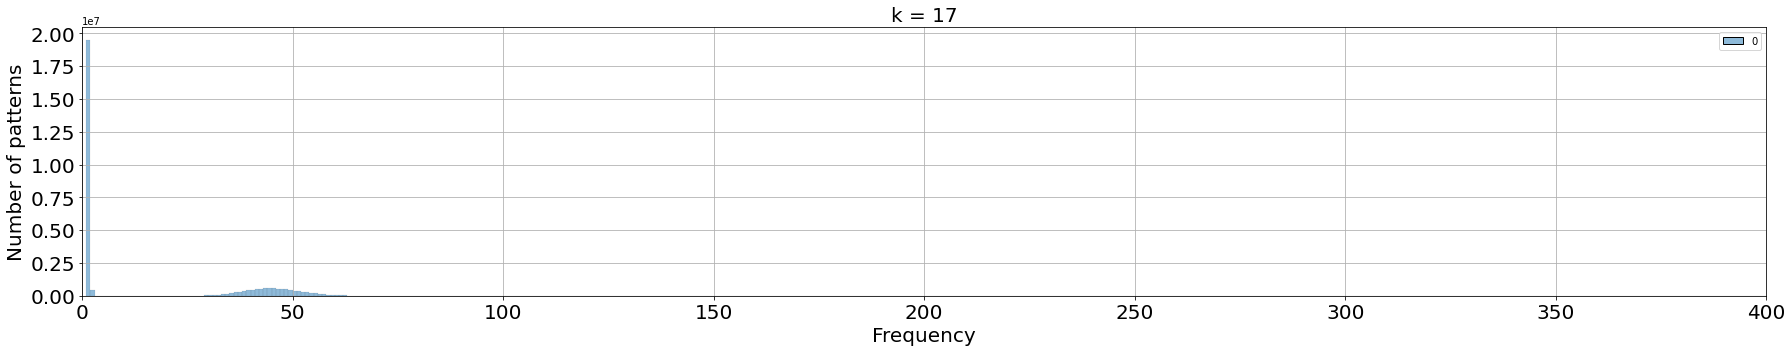

In [ ]:
k = 17

wild_patterns = calculate_patterns_frequency(wild_dna_records, k)
plot_for_k(k, wild_patterns)

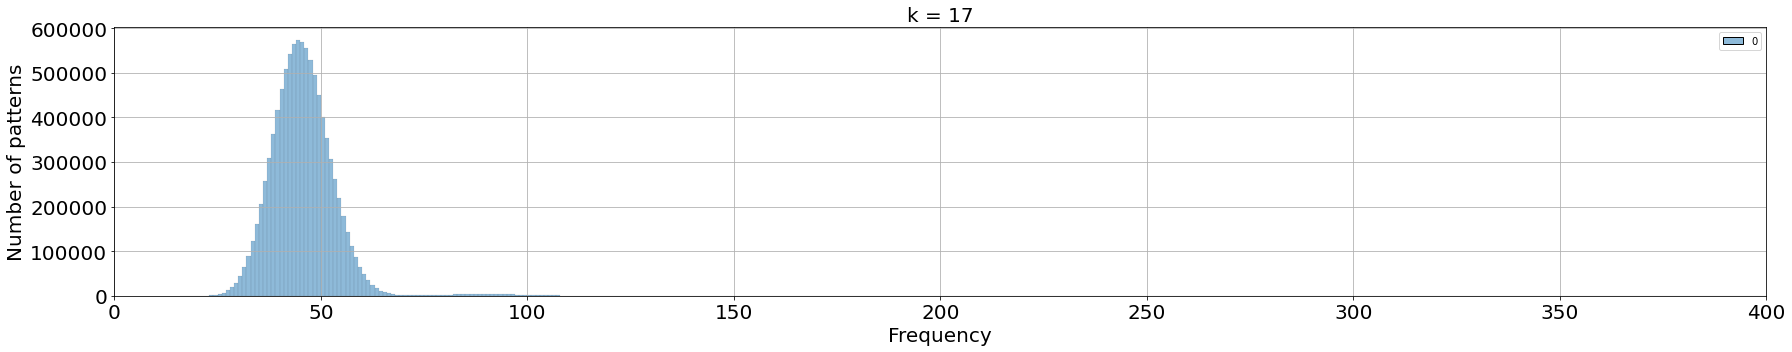

In [ ]:
filtered_wild = {k: v for k, v in wild_patterns.items() if v > outliers_thr}

del wild_patterns
plot_for_k(k, filtered_wild)
del filtered_wild

Still, not good enough.

### What about k = 14?

  0%|          | 0/1993167 [00:00<?, ?it/s]

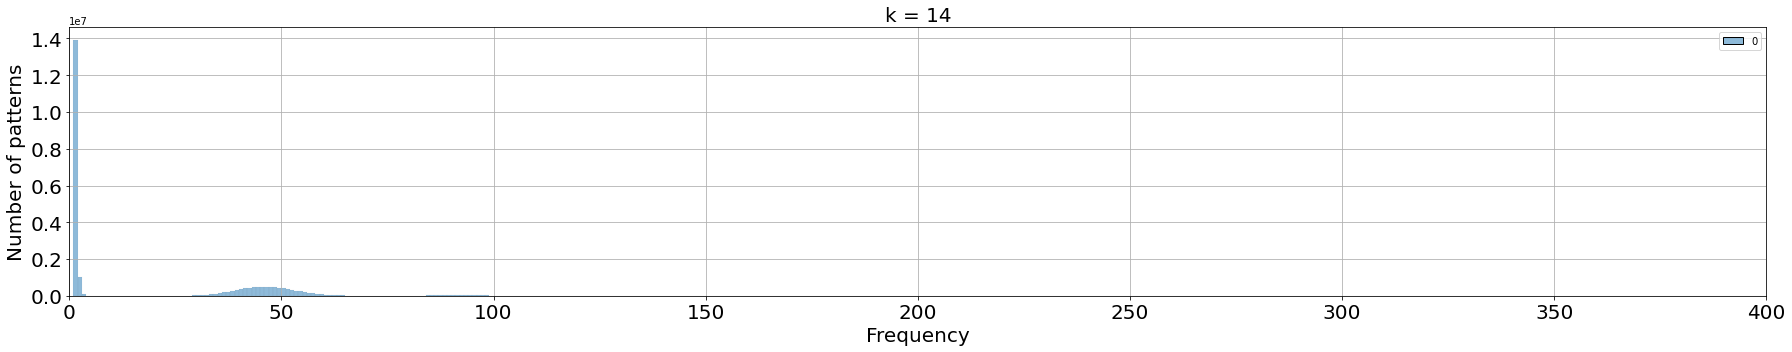

In [ ]:
# %%time

k = 14

wild_patterns = calculate_patterns_frequency(wild_dna_records, k)
plot_for_k(k, wild_patterns)

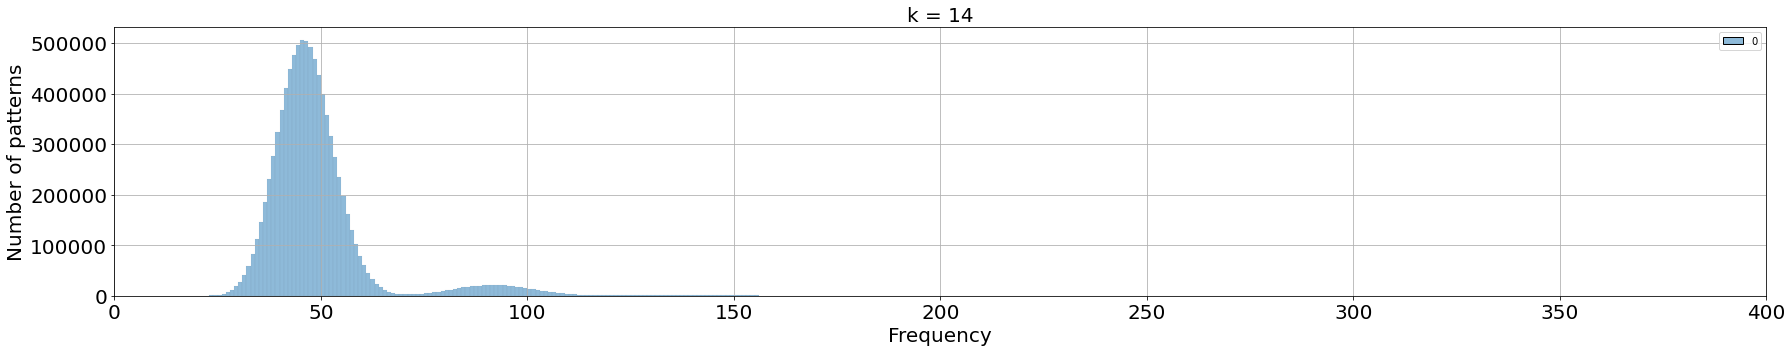

In [ ]:
filtered_wild = {k: v for k, v in wild_patterns.items() if v > outliers_thr}

del wild_patterns
plot_for_k(k, filtered_wild)
del filtered_wild

Hurray! Now we can clearly see the "hills" for lambda and the double lambda (and even triple, if you look really carefully). What if we go for an even smaller k?

### Filnally, k = 11

  0%|          | 0/1993167 [00:00<?, ?it/s]

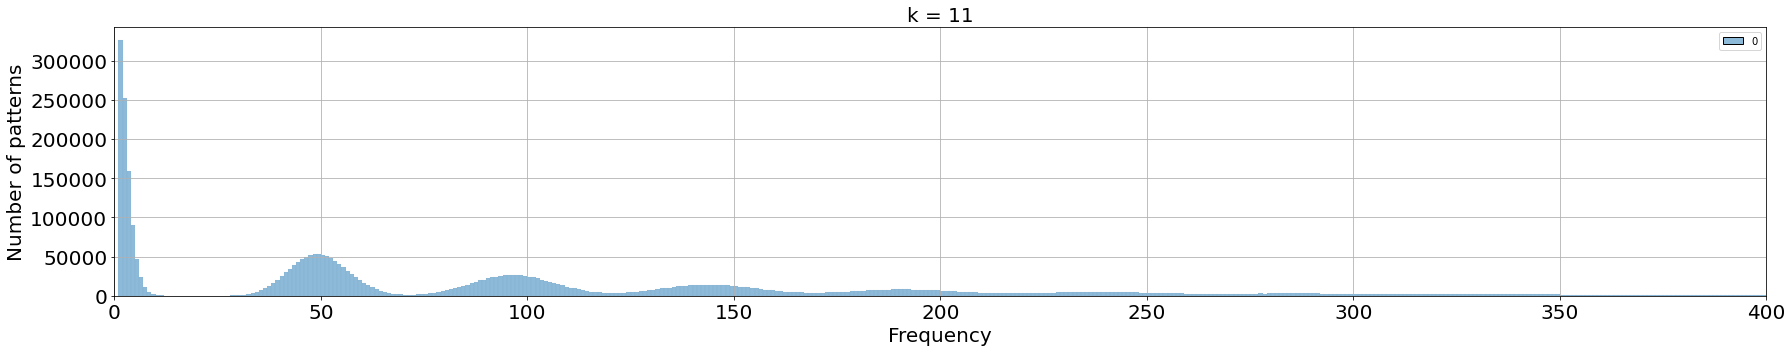

In [ ]:
# %%time

k = 11

wild_patterns = calculate_patterns_frequency(wild_dna_records, k)
plot_for_k(k, wild_patterns)

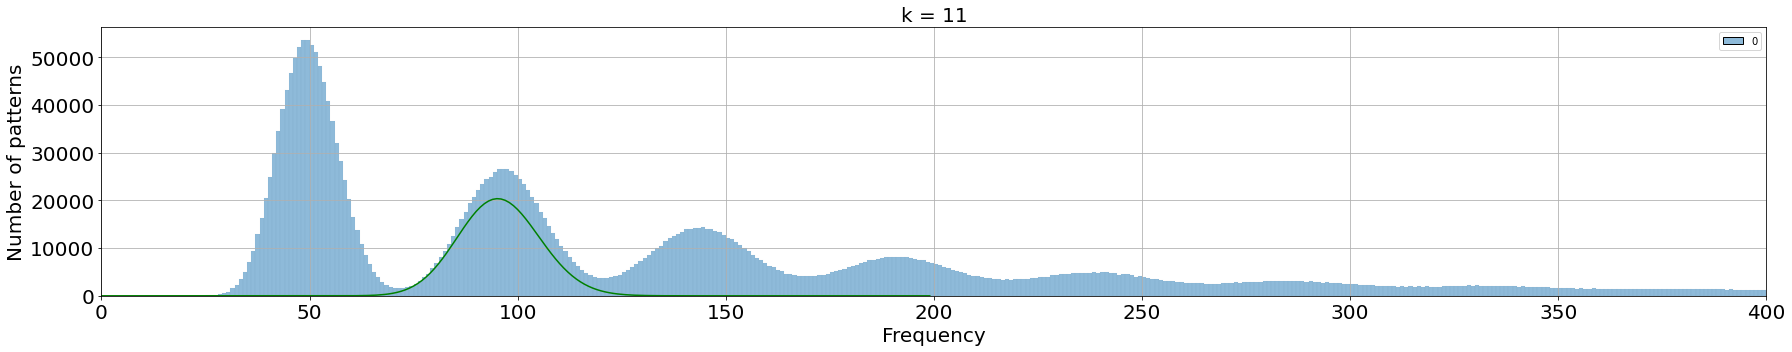

In [ ]:
filtered_wild = {k: v for k, v in wild_patterns.items() if v > outliers_thr}

del wild_patterns
plot_for_k(k, filtered_wild, plot_theoretical=True)
del filtered_wild

This is exactly what we expected to see. However, if we try to plot the theoretical Poisson distribution described above, its center turns out to be of twice greater value of what we expected.

After having a closer look at the dataset we understood that it is completely ok. We have 2 DNA strands (coming from the double helix) in a sample coming in two different versions: the forward one and the reverse complement one. This is why we get 2 times the size of the genome as quantity of DNA.

Although the results we got for k = 11 are the closest to what we expected to see, we decided to use a little larger k, which is 14. This is because small k-mers are much trickier to match and to eventually produce a long enough biological sequence. 

In [ ]:
%%time
k = 14

wild_patterns, wild_origins = calculate_patterns_frequency_with_origin(wild_dna_records, k)
filtered_wild = {k: v for k, v in wild_patterns.items() if v > outliers_thr}
del wild_patterns

mutated_patterns, mutated_origins = calculate_patterns_frequency_with_origin(mutated_dna_records, k)
filtered_mutated = {k: v for k, v in mutated_patterns.items() if v > outliers_thr}
del mutated_patterns

  0%|          | 0/1993167 [00:00<?, ?it/s]

  0%|          | 0/1993167 [00:00<?, ?it/s]

CPU times: user 21min 15s, sys: 24.2 s, total: 21min 40s
Wall time: 21min 44s


## Let's identify those k-mers which are present in the wild gene and not in the mutated one and vice-versa

To reconstruct the part of the strain which is different between the wild and the variant salmonella, we need to first find the k-mers which are present in the mutated gene and are absent in the original, the wild one. We then do the same thing with the wild genom.

In [ ]:
wild_not_mutated_dict = {k: v for k, v in filtered_wild.items() if k not in filtered_mutated.keys()}
mutated_not_wild_dict = {k: v for k, v in filtered_mutated.items() if k not in filtered_wild.keys()}

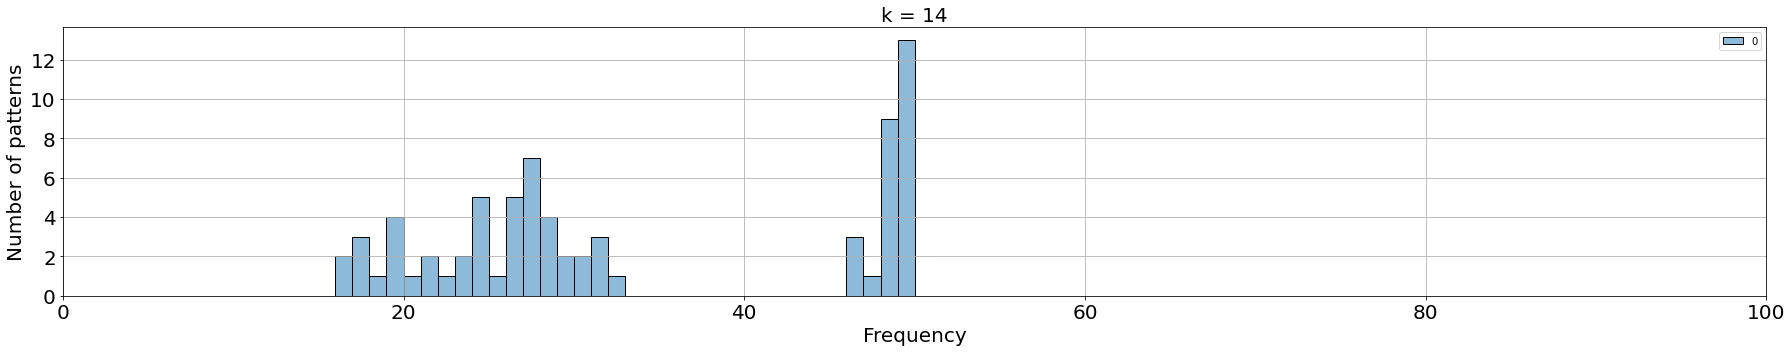

In [ ]:
plot_for_k(k, wild_not_mutated_dict, x_lim=100)

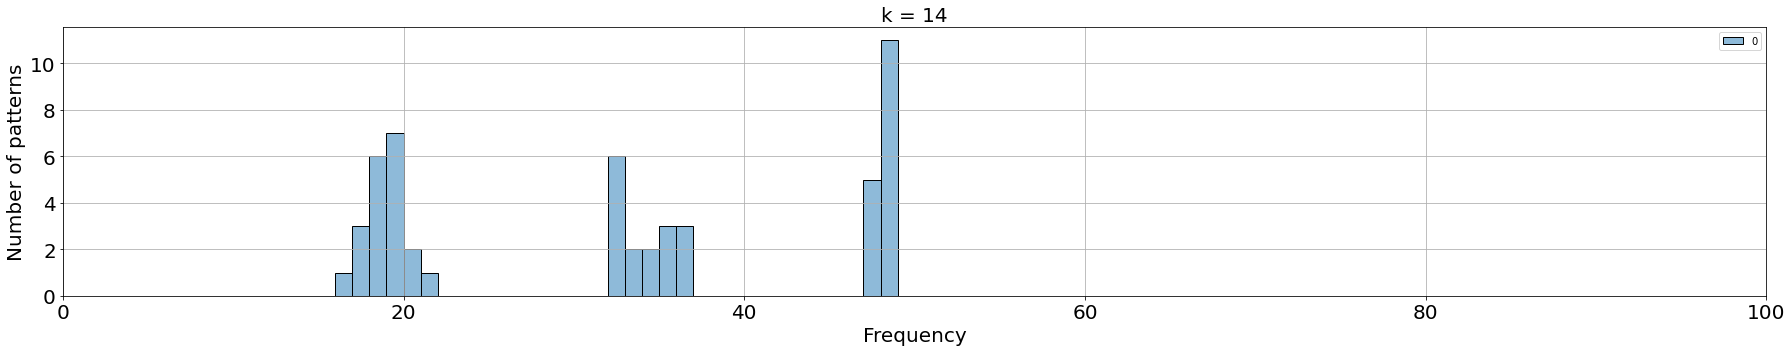

In [ ]:
plot_for_k(k, mutated_not_wild_dict, x_lim=100)

#### Some important notes on thresholding

We can see clearly that on both the graphs there is a surprising number of kmers at the very end of the left slope of the distribution, which is at around 20. Those are, for sure, outliers. 

But where could they come from? It turns out it is quite tricky to find the right threshold so that we get rid of all the outliers and don't accidently miss some k-mers, which might occur much less frequently in one original strain then in the other one.

This is why we decided to first filter out ouliers with a relatively soft threshold of 15, and then get rid of the rest using 25 (see code below).

## Now let's come up with the algorithm to build the sequences of genes from the found k-mers!

It turns out the kmers could be matched back into sequences quite easily. The python dictionaries are actually ordered, the items come in the order in which they were added to the dictionary. The k-mers containing the mutation go one after another in a read. Hence, we can simply iterate over the dictionary and stack the kmers on one another.

In [ ]:
def build_sequences(patterns, thr=25):
    """
    The function builds a genetic sequence from the given kmers.

    inputs: patterns: dict like {'kmer': number of its occurences}
            thr: int, the frequency below which the kmers 
            are considered as erors
    """
    result = None
    sequences = []

    for k, v in patterns.items():
        if v >= thr: 
            if result is None:
                result = copy.copy(k)
            elif result[-13:] == k[:-1]:
                result += k[-1:]
            elif result[-12:] == k[:-2]:
                result += k[-2:]
            elif result[-11:] == k[:-3]:
                result += k[-3:]
            else:
                sequences.append(result)
                result = copy.copy(k)

    sequences.append(result)
    return sequences

In [ ]:
wild_sequences = build_sequences(wild_not_mutated_dict)
mutated_sequences = build_sequences(mutated_not_wild_dict)

In [ ]:
mutated_sequences

['GCTTCTGGGCGAGGGGACGGGTTGTTAAA', 'TTTAACAACCCGTCCCCTCGCCCAGAAGC']

## Matching the resulting sequences using the Levenshtein distance

We can now simply use the Levenshtein distance to find the pairs of the most similar sequences of wild and variant strains.

In [ ]:
# an array of matched wild and mutated genes
alligned_sequences = []

def allign(w, m):
    """
    The function alligns two genetic strings, for better visualization.

    inputs: w and m – strings of wild and mutated genes
    ouput: a dictionary of alligned sequences like 
           {'wild': wild sequence, 'mutated': mutated_sequence}
    """
    if w[:3] == m[:3]:
        return {'wild': w[:min(len(w), len(m))], 'mutated': m[:min(len(w), len(m))]}
    elif w[-3:] == m[-3:]:
        return {'wild': w[-min(len(w), len(m)):], 'mutated': m[-min(len(w), len(m)):]}
    else:
        return {'wild': w[:], 'mutated': m[:]}


# let's fill the the array of matched sequences
for w in wild_sequences:
    for m in mutated_sequences: 
        if lev.distance(w, m) <= 5:
            pair = allign(w, m)
            print('wild')
            print(pair['wild'])
            print()
            print('mutated')
            print(pair['mutated'])
            print()     
            print('---------------------------')
            print()
            alligned_sequences.append(pair)

wild
TTCTGGGCGAGTTTACGGGTTGTTAAA

mutated
TTCTGGGCGAGGGGACGGGTTGTTAAA

---------------------------

wild
TTTAACAACCCGTAAACTCGCCCAGAA

mutated
TTTAACAACCCGTCCCCTCGCCCAGAA

---------------------------



Hurray! We have found the deadly mutation! Note that the mutations are found in both the forward and the reverse sequences.

## Validating results the BLAST database

Now we would like to validate the results we got. To do so, we will use the BLAST database, which may provide us with more information about the resulting biological sequence. Unfortunately, using k-mers of length 14 and a mutated fragment of length 3 one cannot expect to build a sequence of lenght greater than 29, which is not enough for queries in BLAST.

To tackle this problem, we simply retrieve the original reads containing the k-mers of the sequence and provide the search engine with them.

In [ ]:
def return_containing_reads(alligned_sequences_pair, mutated_origins, wild_origins, 
                          mutated_dna_records, wild_dna_records, k=14):
    """
    Given as input a dictionary containing the mutated and wild sequences, 
    returns the containing reads.
    """
    idx = None
    result = {}

    for i, letter in enumerate(alligned_sequences_pair['wild']):
        if alligned_sequences_pair['mutated'][i] != letter:
            idx = i
            break

    target = alligned_sequences_pair['mutated'][max(idx-k+1, 0): 
    min(idx+k, len(alligned_sequences_pair['mutated']))]

    for i in range(len(target)):
        kmer = target[i:i+k]
        n = mutated_origins[kmer]
        if n is not None:
            seq = mutated_dna_records[n]
            result['mutated'] = seq
            break
    
    ########

    target = alligned_sequences_pair['wild'][max(idx-k+1, 0): 
    min(idx+k, len(alligned_sequences_pair['wild']))]

    for i in range(len(target)):
        kmer = target[i:i+k]
        n = wild_origins[kmer]
        if n is not None:
            seq = wild_dna_records[n]
            result['wild'] = seq
            break

    return result

containig_reads = [return_containing_reads(alligned_sequences[0], mutated_origins, 
                          wild_origins, mutated_dna_records, wild_dna_records),
                   return_containing_seq(alligned_sequences[1], mutated_origins, 
                          wild_origins, mutated_dna_records, wild_dna_records)]

In [ ]:
def print_mathed_reads(containing_reads):
    for seq in containing_reads:
        wild = seq['wild']
        mutated = seq['mutated']
        alignments = pairwise2.align.globalms(wild, mutated, 1, -1, -5, -5, one_alignment_only=True, penalize_end_gaps=False)

        for a in alignments:
            print(format_alignment(*a))

print_mathed_reads(containing_reads)

------------------------------------------------------------------------------------------------------------------------------------------------------------------TAGGCTGCTCTACACCTAGCTTCTGGGCGAGTTTACGGGTTGTTAAACCTTCGATTCCGACCTCATTAAGCAGCTCTAATGCGCTGTTAATCACTTTACTTTTATCTAATCTAGACATCATTAATTCCTAATTTTTGTTGACACTCTATCATTGATAGAGTTATTTTACCACTCCCTATCAGTGATAGAGAAAAGTGAAATGAATAGTTCGACAAAGATCGCATTGGTAATTACGTTACTCGATGCCATG
                                                                                                                                                                  |||||||||||||||||||||||||||||||...||||||||||||||||||||||||||||||||||||||||||||||||||||||                                                                                                                                                                  
GTTGACTTAGTAAAGCACATCTAAAACTTTTAGCGTTATTACGTAAAAAATCTTGCCAGCTTTCCCCTTCTAAAGGGCAAAAGTGAGTATGGTGCCTATCTAACATCTCAATGGCTAAGGCGTCGAGCAAAGCCCGCTTATTTTTTACATGCCAATACAATGTAGGCTGCTCTA

### Searching in BLAST...

In [ ]:
from Bio.Seq import Seq
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

read = containig_reads[1]['mutated']
my_seq = Seq(read)

result_handle = NCBIWWW.qblast("blastx", "nr", my_seq, 
                               entrez_query='Salmonella enterica[organism]')
blast_record = NCBIXML.read(result_handle)
result_handle.close()

In [ ]:
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        print(alignment.title)
        break
    break

gb|EAW3951864.1| TetR family transcriptional regulator [Salmonella enterica] >gb|EBZ7877931.1| TetR family transcriptional regulator [Salmonella enterica subsp. enterica serovar Kentucky] >gb|ECH9963169.1| TetR family transcriptional regulator [Salmonella enterica subsp. enterica serovar 4,[5],12:i:-] >gb|ECM7671002.1| TetR family transcriptional regulator [Salmonella enterica subsp. enterica serovar Dublin] >gb|EFH8818463.1| TetR family transcriptional regulator [Escherichia coli] >tpg|HAB2210208.1| TetR family transcriptional regulator [Salmonella enterica subsp. enterica]


Hurray! This is exactly what was expected. 

## Conclusion

Playing a role of the consulting team, we managed to provide TATFAR with a straightforward solution. Our code works in linear time, simple to utilize and makes use of Biopython library. The obtained results were successfully validated using the BLAST database. We hope that our employer was fully satisfied with our work and we will be payed as it was detailed in the estimation of the costs we sent to the company previously. We also hope, of course, that it will help the TATFAR team to develop a new antibiotic which would stop the disastrous outspread of the variant bacteria.